In [1]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")


GPU is available
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU


# TASK1: Linear Classifier using Pytorch on MNIST Data
A linear classifier is a machine learning model that uses a linear function to categorize data into multiple classes.   
It calculates a weighted sum of input features, adds a bias term, and then applies an activation function to obtain class probabilities.   
In PyTorch, you can create a linear classifier using the nn.Linear module, specifying the input features and output classes, with automatic parameter initialization.  

For multiclass classification (using one-hot encoding for class labels):

f(x) = softmax(**W**⋅x+**b**)

Where:

* f(x) is the predicted class or class probabilities for the input data 

* **W** is a matrix of weight vectors for each class.

* x is the input feature vector.

* **b** is a vector of bias terms for multiclass classification.

* ⋅ represents the dot product (matrix multiplication for multiclass).

* {**softmax**}() is the softmax function that produces a probability distribution over classes for multiclass classification.


## Step 1: Import the Required Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import struct
from array import array
from os.path  import join

%matplotlib inline
import random
import matplotlib.pyplot as plt

## Step 2: Load the Data
### Dataset Link
https://www.kaggle.com/datasets/hojjatk/mnist-dataset/

### Content
The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. 
Four files are available:  


* train-images-idx3-ubyte.gz: training set images (9912422 bytes)
* train-labels-idx1-ubyte.gz: training set labels (28881 bytes)
* t10k-images-idx3-ubyte.gz: test set images (1648877 bytes)
* t10k-labels-idx1-ubyte.gz: test set labels (4542 bytes)

In [3]:
#
# MNIST Data Loader Class copied from kaggle where the datset has been downloaded
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [4]:
#
# Set file paths based on added MNIST Datasets present
#
input_path = './archive'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')


mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [5]:
print(len(x_train[0]), len(x_train[0][0]))
print(len(y_train))
print(y_train)

28 28
60000
array('B', [5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6, 1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5, 9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5, 0, 7, 4, 9, 7, 8, 3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3, 0, 4, 6, 5, 2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5, 8, 6, 3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7, 9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9, 6, 5, 7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3, 6, 8, 7, 6, 0, 9, 7, 5, 7, 2, 1, 1, 6, 8, 9, 4, 1, 5, 2, 2, 9, 0, 3, 9, 6, 7, 2

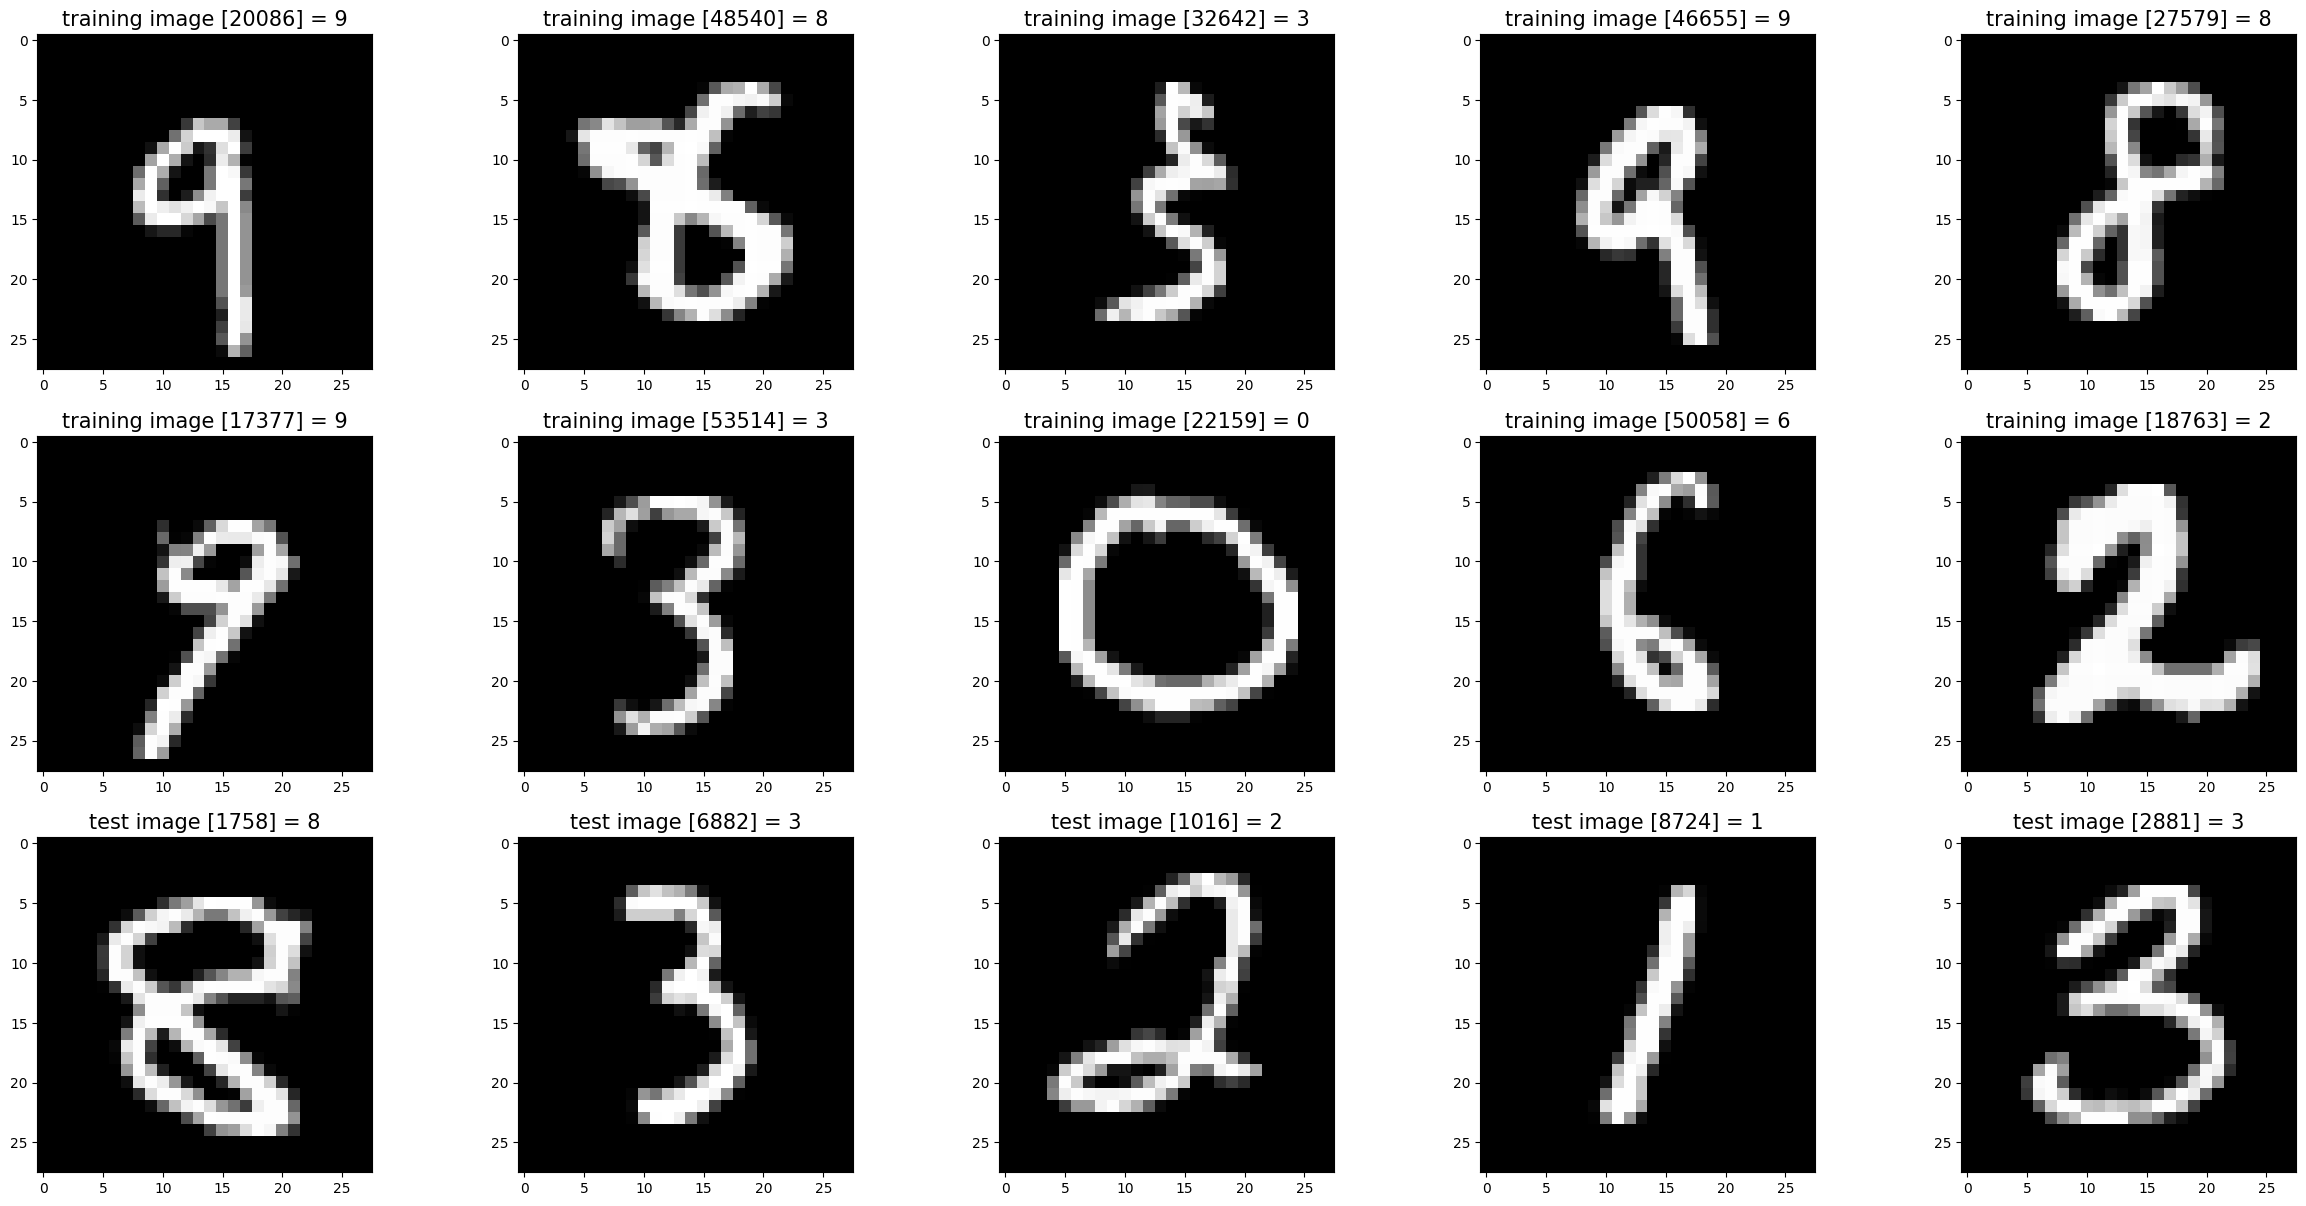

In [6]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

## Step 3: Prepare the Data
We need to convert the data into PyTorch tensors and normalize the features to have a mean of zero and a standard deviation of one.

In [7]:
# Define the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Convert Python lists to NumPy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
# Flatten the input images
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_train.shape, x_test.shape)

# Convert NumPy arrays to PyTorch tensors
x_train_tensor = torch.from_numpy(x_train).to(device)
y_train_tensor = torch.from_numpy(y_train).to(device)
x_test_tensor = torch.from_numpy(x_test).to(device)
y_test_tensor = torch.from_numpy(y_test).to(device)

input_size = x_train.shape[1]
num_classes = 10 

print(x_train_tensor.shape, y_train_tensor.shape)

(60000, 784) (10000, 784)
torch.Size([60000, 784]) torch.Size([60000])


## Step 4: Define the Model
We can define our linear classifier using the nn.Linear module. We will set the number of input features to 28x28 and the number of output classes to 10 (since we have 10 digits 0 to 9).

In [8]:
model1 = torch.nn.Sequential( 
    torch.nn.Linear(in_features = input_size, out_features = num_classes), 
    torch.nn.Softmax(dim=1) 
).to(device)

In [9]:
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x
 
model2 = LinearClassifier(input_size, num_classes).to(device)

In [10]:
model1.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
  (1): Softmax(dim=1)
)>

In [11]:
model2.parameters

<bound method Module.parameters of LinearClassifier(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)>

## Step 5: Train the Model
We can train the model using the CrossEntropyLoss loss function and the SGD optimizer.

Epoch 1/20, Loss: 2.058022241221308
Epoch 2/20, Loss: 2.022179717829487
Epoch 3/20, Loss: 2.0172958306666375
Epoch 4/20, Loss: 2.0095681921759647
Epoch 5/20, Loss: 2.0074174770160016
Epoch 6/20, Loss: 2.0025555332586453
Epoch 7/20, Loss: 2.005116695280014
Epoch 8/20, Loss: 2.0000213534593074
Epoch 9/20, Loss: 1.999684511344316
Epoch 10/20, Loss: 1.9971977838321027
Epoch 11/20, Loss: 1.996586946536229
Epoch 12/20, Loss: 1.9977220051578368
Epoch 13/20, Loss: 1.9552419558008596
Epoch 14/20, Loss: 1.9101753956727636
Epoch 15/20, Loss: 1.9081808191372642
Epoch 16/20, Loss: 1.90428044013123
Epoch 17/20, Loss: 1.9027371270570166
Epoch 18/20, Loss: 1.9031717802669956
Epoch 19/20, Loss: 1.9030417608045567
Epoch 20/20, Loss: 1.901698098126759


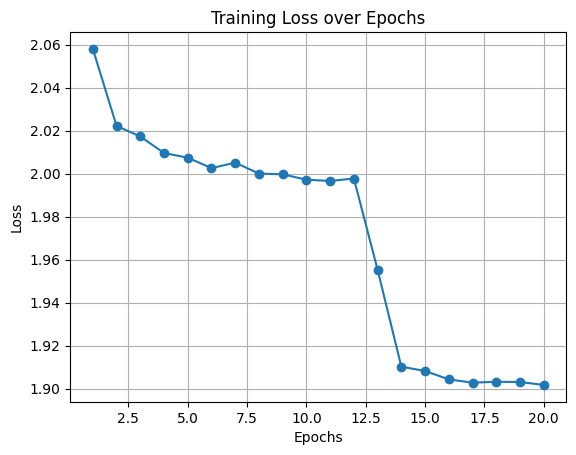

In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

# Create a DataLoader for training data
batch_size = 64
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Training loop
num_epochs = 20  # You can adjust the number of training epochs
all_loss = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model1(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    all_loss.append(running_loss / len(train_loader))
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

# After the training loop is complete, you can plot the loss values.
plt.plot(range(1, num_epochs + 1), all_loss, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

## Step 6: Evaluate the Model
The final step is to evaluate the performance of the linear classifier using the test set. We’ll use the test set to compute the accuracy of the model.

In [13]:
# Evaluate the model on the test data10000
model1.eval()
with torch.no_grad():
    outputs = model1(x_test_tensor.float())
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total * 100
    print(f'Accuracy on test data: {accuracy:.2f}%')

Accuracy on test data: 55.37%


## Testing The Model

In [14]:
# Define the prediction function
def predict_and_show(model, image, true_label):
    # Ensure the model is in evaluation mode
    model1.eval()

    # Convert the image to a PyTorch tensor and move it to the appropriate device
    image_tensor = torch.from_numpy(image).to(device)

    # Ensure the image tensor has the correct shape (flatten it)
    image_tensor = image_tensor.view(1, -1).float()

    # Forward pass to get the predicted label
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    # Convert the image from a flat array to a 28x28 matrix for display
    image_display = image.reshape(28, 28)

    # Display the image and the predicted label
    plt.figure()
    plt.imshow(image_display, cmap='gray')
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted.item()}')
    plt.show()


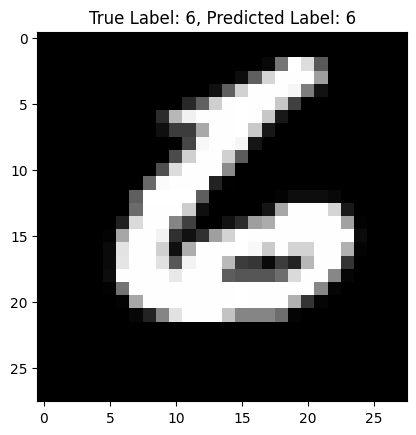

In [15]:
# Example usage
sample_index = 9999  # Replace with the index of the image you want to predict
sample_image = x_test[sample_index]
true_label = y_test[sample_index]

predict_and_show(model1, sample_image, true_label)

# TASK2: 

In [16]:
import torch
import torchvision
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

## Data Loading 

In [65]:
# Load the Iris dataset
iris = load_iris()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    test_size=0.2,
                                                    random_state=42)


In [66]:
print(X_train.shape , y_train.shape)
print(X_test.shape , y_test.shape)
print(type(X_train),type(y_train))

(120, 4) (120,)
(30, 4) (30,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [67]:
# Convert the data to PyTorch tensors and move them to the GPU
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [68]:
print(type(X_train),type(y_train))
print(X_train[0:5])
print(y_train[0:5])

<class 'torch.Tensor'> <class 'torch.Tensor'>
tensor([[4.6000, 3.6000, 1.0000, 0.2000],
        [5.7000, 4.4000, 1.5000, 0.4000],
        [6.7000, 3.1000, 4.4000, 1.4000],
        [4.8000, 3.4000, 1.6000, 0.2000],
        [4.4000, 3.2000, 1.3000, 0.2000]])
tensor([0, 0, 1, 0, 0])


## Data Standardization and Normalization

In [74]:
# Normalize the features
mean = X_train.mean(dim=0)
std = X_train.std(dim=0)
X_max = X_train.max(dim=0).values
X_min = X_train.min(dim=0).values

# X_train = (X_train - mean) / std
# X_test = (X_test - mean) / std

X_train = (X_train - X_min) / (X_max - X_min)
X_test = (X_test - X_min) / (X_max - X_min)

In [75]:
X_max

tensor([7.7000, 4.4000, 6.7000, 2.5000])

In [76]:
mean

tensor([5.8092, 3.0617, 3.7267, 1.1833])

## A Linear Model

In [46]:
# Define the model and move it to the GPU
model1 = torch.nn.Sequential(
    torch.nn.Linear(4, 3),
    torch.nn.Softmax(dim=1)
)

In [47]:
model2 = torch.nn.Sequential(
    torch.nn.Linear(4, 32),  # 4 input features and 32 hidden units with ReLU
    torch.nn.ReLU(),
    torch.nn.Linear(32, 3),  # 32 hidden units to 3 output classes
    torch.nn.Softmax(dim=1)  # Softmax in the output layer
)

In [48]:
model3 = nn.Sequential(
    nn.Linear(4, 3),
    nn.Tanh()  # Use Tanh activation function
)

In [58]:

def run_model(model):
    # Train the model
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    num_epochs = 1000
    all_loss = []
    for epoch in range(num_epochs):
        # Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss every 100 epochs
        all_loss.append(loss.item())
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model
    with torch.no_grad():
        y_pred = model(X_test)
        _, predicted = torch.max(y_pred, dim=1)
        accuracy = (predicted == y_test).float().mean()
        print(f'Test Accuracy: {accuracy.item():.4f}')

    # Plot the loss values
    plt.plot(range(1, num_epochs + 1), all_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.grid(True)
    plt.show()


Epoch [100/1000], Loss: 0.6517
Epoch [200/1000], Loss: 0.6472
Epoch [300/1000], Loss: 0.6432
Epoch [400/1000], Loss: 0.6397
Epoch [500/1000], Loss: 0.6366
Epoch [600/1000], Loss: 0.6337
Epoch [700/1000], Loss: 0.6311
Epoch [800/1000], Loss: 0.6288
Epoch [900/1000], Loss: 0.6267
Epoch [1000/1000], Loss: 0.6247
Test Accuracy: 1.0000


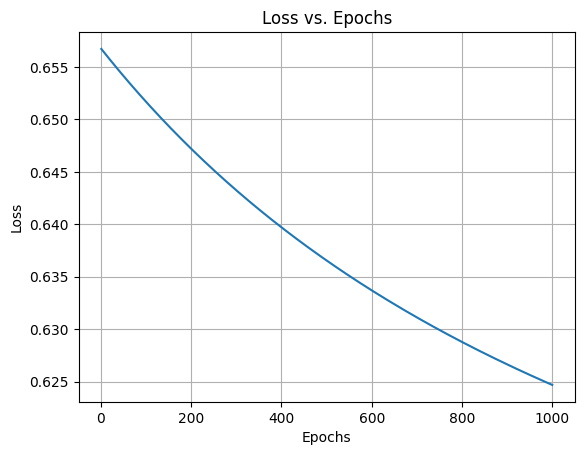

In [59]:
run_model(model1)

Epoch [100/1000], Loss: 0.5882
Epoch [200/1000], Loss: 0.5867
Epoch [300/1000], Loss: 0.5855
Epoch [400/1000], Loss: 0.5844
Epoch [500/1000], Loss: 0.5835
Epoch [600/1000], Loss: 0.5827
Epoch [700/1000], Loss: 0.5820
Epoch [800/1000], Loss: 0.5814
Epoch [900/1000], Loss: 0.5808
Epoch [1000/1000], Loss: 0.5803
Test Accuracy: 1.0000


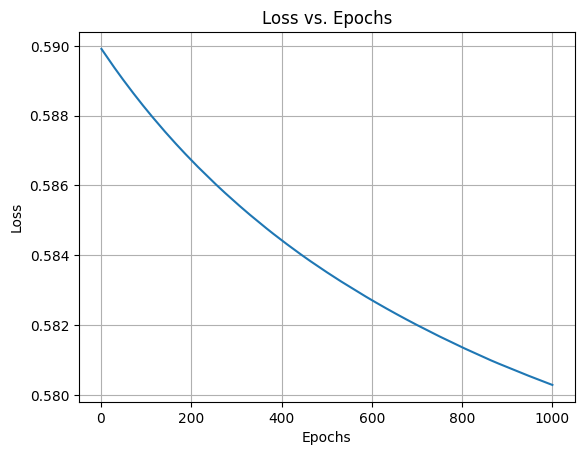

In [60]:
run_model(model2)

Epoch [100/1000], Loss: 0.4364
Epoch [200/1000], Loss: 0.4341
Epoch [300/1000], Loss: 0.4321
Epoch [400/1000], Loss: 0.4304
Epoch [500/1000], Loss: 0.4287
Epoch [600/1000], Loss: 0.4273
Epoch [700/1000], Loss: 0.4260
Epoch [800/1000], Loss: 0.4247
Epoch [900/1000], Loss: 0.4236
Epoch [1000/1000], Loss: 0.4226
Test Accuracy: 1.0000


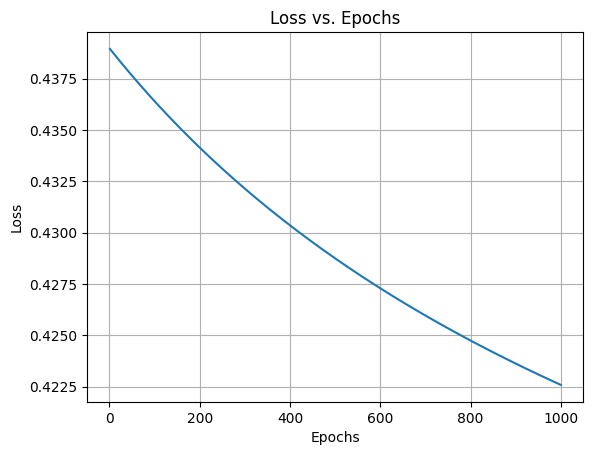

In [61]:
run_model(model3)

# Task3: A simple CNN model for CIFAR10

A convolutional neural network (CNN) for a simple task, such as image classification, we can follow these general steps:

1. Data Preparation:

For image classification, you'll typically have a set of images, each associated with a specific class or label.
Split your dataset into training and testing sets.  

2. Data Preprocessing:

Preprocess your images, which may include resizing, normalization, and augmentation.
Convert your data into a format suitable for training, such as PyTorch tensors.  

3. Model Design:

Design your CNN model. This involves defining the architecture, including convolutional layers, pooling layers, fully connected layers, and the output layer.
Specify the number of filters, kernel sizes, activation functions, and other hyperparameters.  

4. Loss Function and Optimizer:

Choose an appropriate loss function for your task. For classification, you might use Cross-Entropy Loss.
Select an optimizer, such as SGD (Stochastic Gradient Descent) or Adam.  

5. Training:

Train your CNN model on the training dataset using the specified loss function and optimizer.
Monitor training progress, track loss, and evaluate the model's performance on the validation set.  

6. Evaluation:

Evaluate your trained model on the testing dataset to assess its accuracy and performance.  

7. Fine-Tuning (Optional):

If your initial results are not satisfactory, you may need to adjust hyperparameters, model architecture, or the amount of data used for training.  

8. Inference:

Use your trained model to make predictions on new, unseen data.



## CIFAR-10

50,000 images are typically used for training, while the remaining 10,000 images are used for testing and evaluation.  
The images in CIFAR-10 are small and have a fixed size of 32x32 pixels.  
Each class in CIFAR-10 contains an equal number of images (usually 6,000 for training and 1,000 for testing).

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data preprocessing and loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [84]:
for inputs, labels in train_loader:
    print(inputs.shape)
    print(labels.shape)
    print(inputs[0])
    print(labels[0])
    break

torch.Size([64, 3, 32, 32])
torch.Size([64])
tensor([[[ 0.5137,  0.6157,  0.3804,  ..., -0.0039, -0.0118, -0.1765],
         [ 0.4039,  0.2078,  0.5686,  ..., -0.0353, -0.0980, -0.1608],
         [ 0.2235,  0.0196,  0.3961,  ..., -0.1059, -0.0902, -0.0588],
         ...,
         [ 0.7176,  0.4980, -0.1294,  ...,  0.4196,  0.3647,  0.3490],
         [ 0.5373,  0.1529, -0.1843,  ...,  0.4353,  0.3490,  0.4039],
         [ 0.2157, -0.0275, -0.0667,  ...,  0.5608,  0.4118,  0.3804]],

        [[ 0.5137,  0.6157,  0.3804,  ..., -0.0039, -0.0118, -0.1765],
         [ 0.4039,  0.2078,  0.5686,  ..., -0.0353, -0.0980, -0.1608],
         [ 0.2235,  0.0196,  0.3961,  ..., -0.1059, -0.0902, -0.0588],
         ...,
         [ 0.7176,  0.4980, -0.1294,  ...,  0.4196,  0.3647,  0.3490],
         [ 0.5373,  0.1529, -0.1843,  ...,  0.4353,  0.3490,  0.4039],
         [ 0.2157, -0.0275, -0.0667,  ...,  0.5608,  0.4118,  0.3804]],

        [[ 0.5137,  0.6157,  0.3804,  ..., -0.0039, -0.0118, -0.1765],


In [88]:
import torch.nn.functional as F
# Model definition
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.fc1 = nn.Linear(16 * 30 * 30, 64)
        self.fc2 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [90]:
# Training loop
all_loss = []
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    all_loss.append(running_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}')

    

Epoch [1/10], Loss: 1200.1970
Epoch [2/10], Loss: 1098.7823
Epoch [3/10], Loss: 1030.5737
Epoch [4/10], Loss: 974.9524
Epoch [5/10], Loss: 927.7542
Epoch [6/10], Loss: 889.4835
Epoch [7/10], Loss: 851.6450
Epoch [8/10], Loss: 815.0358
Epoch [9/10], Loss: 785.1370
Epoch [10/10], Loss: 751.6738


Test Accuracy: 59.06%


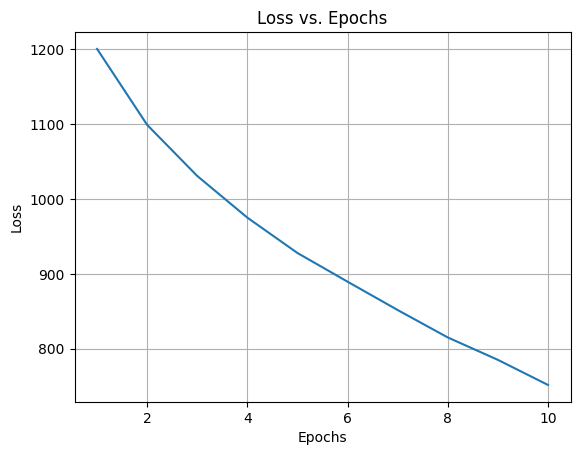

In [91]:
# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


 # Plot the loss values
plt.plot(range(1, num_epochs + 1), all_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.grid(True)
plt.show()